In [0]:
from pyspark.sql import Row
from pyspark.sql.functions import col, split, explode
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, Normalizer
from pyspark.ml.clustering import BisectingKMeans

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("MovieLensReader") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [0]:
raw_movies=sc.textFile("u.item")

In [0]:

movies_rdd = raw_movies.map(lambda line: line.split("|")).filter(lambda x: len(x) > 1)  # Ignore bad rows

movies_rdd = movies_rdd.map(lambda x: Row(movieId=int(x[0]), title=x[1], genres=x[2] if len(x) > 2 else "Unknown"))

movies_df = spark.createDataFrame(movies_rdd)
print(movies_df)

DataFrame[movieId: bigint, title: string, genres: string]


In [0]:
movies_df = movies_df.withColumn("genres", split(col("genres"), ","))  # Split genres into lists
movies_df = movies_df.withColumn("genre", explode(col("genres")))  # Flatten genres for TF-IDF


In [0]:
tokenizer = Tokenizer(inputCol="genre", outputCol="words")
words_data = tokenizer.transform(movies_df)
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=50)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

In [0]:
normalizer = Normalizer(inputCol="features", outputCol="norm_features")
normalized_data = normalizer.transform(rescaled_data)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field norm_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


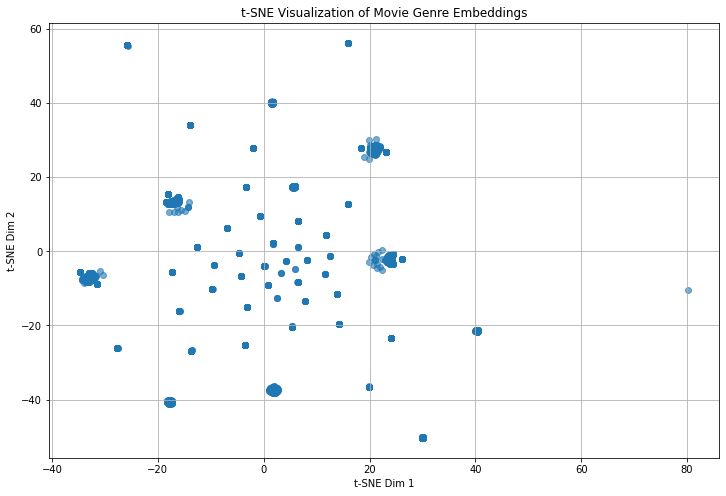

In [0]:
# Convert Spark DataFrame to Pandas for t-SNE
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extract necessary columns
vector_df = normalized_data.select("movieId", "title", "norm_features").toPandas()
vector_df["norm_features"] = vector_df["norm_features"].apply(lambda x: x.toArray())
features = np.vstack(vector_df["norm_features"].values)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6)
plt.title("t-SNE Visualization of Movie Genre Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()


In [0]:
bkm = BisectingKMeans(featuresCol="norm_features", predictionCol="cluster", k=10)
model = bkm.fit(normalized_data)
clustered_movies = model.transform(normalized_data)


In [0]:
def recommend_movies(movie_id, num_recommendations=5):
    cluster_id = clustered_movies.filter(col("movieId") == movie_id).select("cluster").collect()[0][0]
    recommendations = clustered_movies.filter(col("cluster") == cluster_id).limit(num_recommendations)
    return recommendations.select("movieId", "title").collect()


In [0]:
movie_id = 691
recommended_movie = recommend_movies(movie_id, 100)
print(recommended_movie)
# Display Recommendations
print(f"\nMovies similar to {movie_id}:")
for row in recommended_movie:
    print(f"Movie ID: {row['movieId']} - {row['title']}")

[Row(movieId=13, title='Mighty Aphrodite (1995)'), Row(movieId=21, title='Muppet Treasure Island (1996)'), Row(movieId=22, title='Braveheart (1995)'), Row(movieId=23, title='Taxi Driver (1976)'), Row(movieId=30, title='Belle de jour (1967)'), Row(movieId=109, title='Mystery Science Theater 3000: The Movie (1996)'), Row(movieId=112, title='Flipper (1996)'), Row(movieId=113, title='Horseman on the Roof, The (Hussard sur le toit, Le) (1995)'), Row(movieId=114, title='Wallace & Gromit: The Best of Aardman Animation (1996)'), Row(movieId=116, title='Cold Comfort Farm (1995)'), Row(movieId=118, title='Twister (1996)'), Row(movieId=120, title='Striptease (1996)'), Row(movieId=126, title='Spitfire Grill, The (1996)'), Row(movieId=135, title='2001: A Space Odyssey (1968)'), Row(movieId=167, title='Private Benjamin (1980)'), Row(movieId=172, title='Empire Strikes Back, The (1980)'), Row(movieId=186, title='Blues Brothers, The (1980)'), Row(movieId=192, title='Raging Bull (1980)'), Row(movieId=19

In [0]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col

# Initialize Spark Session
spark = SparkSession.builder.appName("MovieLensEval").getOrCreate()

# Load MovieLens 100K dataset using Spark
ratings_rdd = spark.sparkContext.textFile("u.data") \
    .map(lambda x: x.split("\t")) \
    .map(lambda x: Row(user_id=int(x[0]), movie_id=int(x[1]), rating=int(x[2])))

ratings_df = spark.createDataFrame(ratings_rdd)

target_user_id = 100  # target user

# Get movies rated by the target user
user_rated_movies = (
    ratings_df.filter(col("user_id") == target_user_id)
    .select("movie_id", "rating")
    .rdd.map(lambda row: (row.movie_id, row.rating))
    .collectAsMap()
)
print(user_rated_movies)
# Consider movies with rating >= 2 as "liked"
liked_movies = {movie for movie, rating in user_rated_movies.items() if rating >= 2}


# Extract movie IDs from Spark Rows
recommended_movies = {row.movieId for row in recommended_movie}

# Function to evaluate recommendations for a single user
def evaluate_recommendations(recommended_movies, liked_movies):
    relevant = recommended_movies.intersection(liked_movies)

    precision = len(relevant) / len(recommended_movies) if recommended_movies else 0
    recall = len(relevant) / len(liked_movies) if liked_movies else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Evaluate for the specific user
precision, recall, f1 = evaluate_recommendations(recommended_movies, liked_movies)
print(f"User {target_user_id} -> Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


{344: 4, 354: 2, 268: 3, 321: 1, 355: 4, 750: 4, 266: 2, 288: 2, 302: 4, 340: 3, 689: 3, 905: 3, 289: 3, 691: 4, 316: 5, 1236: 3, 342: 3, 990: 3, 333: 3, 752: 4, 323: 3, 348: 3, 313: 5, 292: 2, 1238: 2, 879: 4, 300: 4, 328: 4, 1235: 4, 1237: 3, 678: 3, 286: 3, 908: 1, 690: 4, 874: 1, 880: 1, 349: 3, 310: 3, 347: 4, 1234: 1, 270: 3, 1233: 3, 326: 3, 269: 4, 258: 4, 900: 4, 886: 3, 294: 4, 272: 4, 881: 1, 895: 2, 892: 2, 887: 2, 885: 2, 346: 3, 751: 4, 271: 3, 898: 4, 315: 5}
User 100 -> Precision: 0.0400, Recall: 0.0755, F1-score: 0.0523


In [0]:
ratings_df.filter((col("user_id") == 100) ).show()


+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|    100|     344|     4|
|    100|     354|     2|
|    100|     268|     3|
|    100|     321|     1|
|    100|     355|     4|
|    100|     750|     4|
|    100|     266|     2|
|    100|     288|     2|
|    100|     302|     4|
|    100|     340|     3|
|    100|     689|     3|
|    100|     905|     3|
|    100|     289|     3|
|    100|     691|     4|
|    100|     316|     5|
|    100|    1236|     3|
|    100|     342|     3|
|    100|     990|     3|
|    100|     333|     3|
|    100|     752|     4|
+-------+--------+------+
only showing top 20 rows

